In [29]:
# Import necessary libraries for data preprocessing, visualization, and model training
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
from PIL import Image
import timm
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [30]:
# Configure device (use GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define paths to the dataset files
train_csv_path = '/kaggle/input/ai-vs-human-generated-dataset/train.csv'
test_csv_path = '/kaggle/input/ai-vs-human-generated-dataset/test.csv'
train_data_dir = '/kaggle/input/ai-vs-human-generated-dataset/train_data'
test_data_dir = '/kaggle/input/ai-vs-human-generated-dataset/test_data_v2'

# Load and inspect the CSV files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# Display the first few rows to understand the structure
print("Train CSV head:")
print(train_df.head())
print("\nTest CSV head:")
print(test_df.head())

Using device: cuda
Train CSV head:
   Unnamed: 0                                        file_name  label
0           0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1
1           1  train_data/041be3153810433ab146bc97d5af505c.jpg      0
2           2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1
3           3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0
4           4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1

Test CSV head:
                                                  id
0  test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg
1  test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg
2  test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg
3  test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg
4  test_data_v2/a16495c578b7494683805484ca27cf9f.jpg


In [31]:
# Define a custom transform for FFT-based frequency domain preprocessing
class FFTTransform:
    def __call__(self, img):
        # Convert PIL image to numpy array
        img = np.array(img)
        fft_channels = []
        # Apply FFT to each RGB channel
        for channel in range(img.shape[2]):
            fft = np.fft.fft2(img[:, :, channel])
            fft_shift = np.fft.fftshift(fft)
            # Compute magnitude spectrum and normalize
            magnitude = np.log1p(np.abs(fft_shift))
            magnitude = (magnitude - magnitude.min()) / (magnitude.max() - magnitude.min())
            fft_channels.append(magnitude)
        # Average the magnitude across channels
        fft_img = np.mean(fft_channels, axis=0)
        fft_img = np.expand_dims(fft_img, axis=2)
        # Concatenate the frequency channel with RGB channels
        img_with_fft = np.concatenate((img, fft_img), axis=2)
        return Image.fromarray((img_with_fft * 255).astype(np.uint8))

# Define the full preprocessing pipeline for training
transform = transforms.Compose([
    # Resize images to 224x224 (standard for models like CoAtNet)
    transforms.Resize((224, 224)),
    # Apply data augmentation to prevent overfitting
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    # Add frequency domain preprocessing
    FFTTransform(),
    # Convert to tensor
    transforms.ToTensor(),
    # Normalize with ImageNet mean/std for RGB and an additional channel for FFT
    transforms.Normalize(mean=[0.485, 0.456, 0.406, 0.5], std=[0.229, 0.224, 0.225, 0.5])
])

# Define a transform for test data (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    FFTTransform(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406, 0.5], std=[0.229, 0.224, 0.225, 0.5])
])

In [32]:
import os

# Define a custom dataset class to load images from CSV
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, is_test=False):
        # Load the CSV file
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        # Return the total number of samples
        return len(self.data)

    def __getitem__(self, idx):
        # Get the image path based on whether it's a test dataset
        if self.is_test:
            img_path_raw = self.data.iloc[idx]['id']  # Test CSV has 'id' column
        else:
            img_path_raw = self.data.iloc[idx]['file_name']  # Train CSV has 'file_name' column
        
        # Extract the filename by removing the directory prefix (e.g., 'train_data/' or 'test_data_v2/')
        img_name = os.path.basename(img_path_raw)
        # Construct the full path by joining with root_dir
        img_path = os.path.join(self.root_dir, img_name)
        
        # Load the image
        image = Image.open(img_path).convert('RGB')
        # Get the label (if available, else -1 for test set)
        label = self.data.iloc[idx]['label'] if 'label' in self.data.columns else -1
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        return image, label

# Create datasets for training and testing
train_dataset = CustomDataset(
    csv_file=train_csv_path,
    root_dir=train_data_dir,
    transform=transform,
    is_test=False
)

test_dataset = CustomDataset(
    csv_file=test_csv_path,
    root_dir=test_data_dir,
    transform=test_transform,
    is_test=True
)

# Print dataset sizes to verify
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 79950
Number of test samples: 5540


In [33]:
# Create DataLoaders for training and testing
train_loader = DataLoader(
    train_dataset,
    batch_size=32,           # Batch size suitable for T4 GPU
    shuffle=True,            # Shuffle training data for better generalization
    num_workers=4,          # Use multiple workers for faster data loading
    pin_memory=True         # Enable pin_memory for faster data transfer to GPU
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,           # No shuffling for test data
    num_workers=4,
    pin_memory=True
)

# Print the size of the datasets to verify loading
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 79950
Number of test samples: 5540


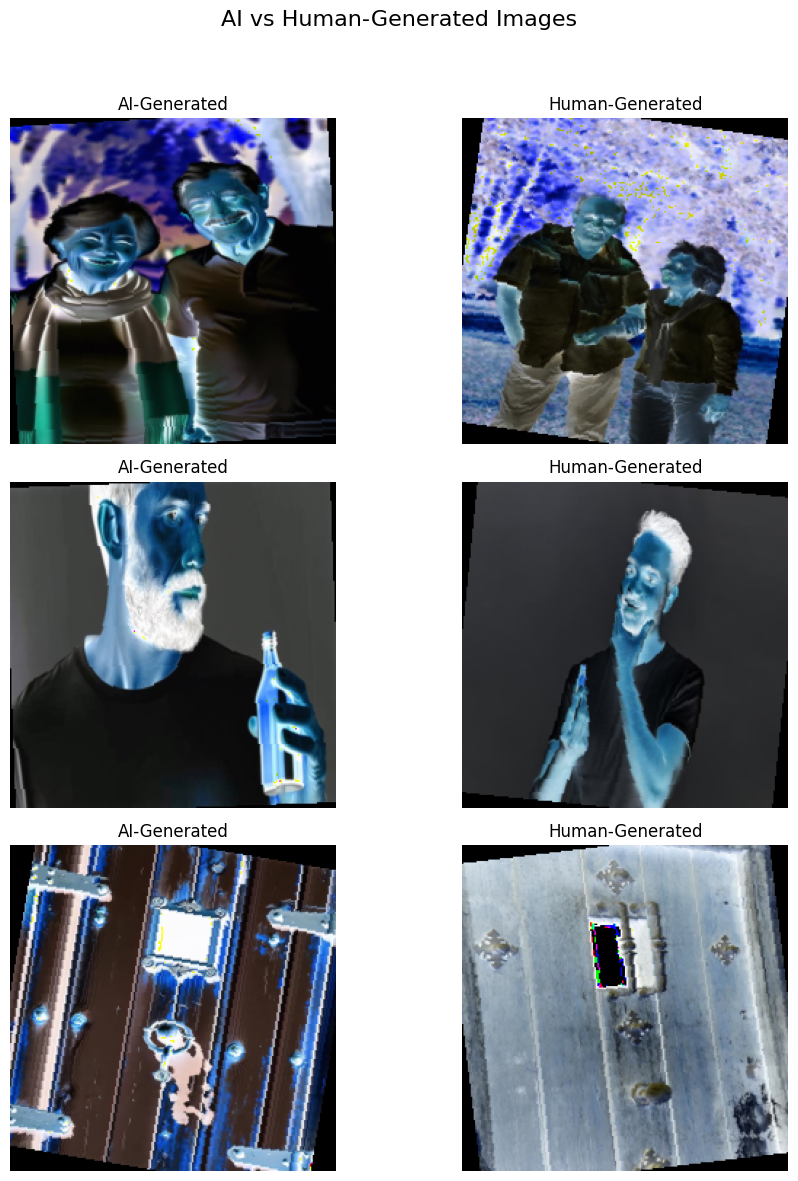

In [51]:
# Function to denormalize images for visualization
def denormalize(tensor):
    # Define mean and std for RGB channels (ignoring the FFT channel for visualization)
    mean = torch.tensor([0.485, 0.456, 0.406], device=tensor.device).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=tensor.device).view(3, 1, 1)
    # Denormalize the RGB channels
    tensor = tensor[:3, :, :]  # Take only RGB channels
    tensor = tensor * std + mean
    tensor = tensor.clamp(0, 1)
    return tensor

# Collect AI and human-generated image pairs
ai_images = []
human_images = []
for img, label in train_dataset:
    if label == 1 and len(ai_images) < 3:  # AI-generated (label = 1)
        ai_images.append(img)
    elif label == 0 and len(human_images) < 3:  # Human-generated (label = 0)
        human_images.append(img)
    if len(ai_images) == 3 and len(human_images) == 3:
        break

# Plot the first 3 pairs of AI vs Human images
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
fig.suptitle("AI vs Human-Generated Images", fontsize=16)

for i in range(3):
    # AI image
    ai_img = denormalize(ai_images[i]).permute(1, 2, 0).numpy()
    axes[i, 0].imshow(ai_img)
    axes[i, 0].set_title("AI-Generated")
    axes[i, 0].axis('off')

    # Human image
    human_img = denormalize(human_images[i]).permute(1, 2, 0).numpy()
    axes[i, 1].imshow(human_img)
    axes[i, 1].set_title("Human-Generated")
    axes[i, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

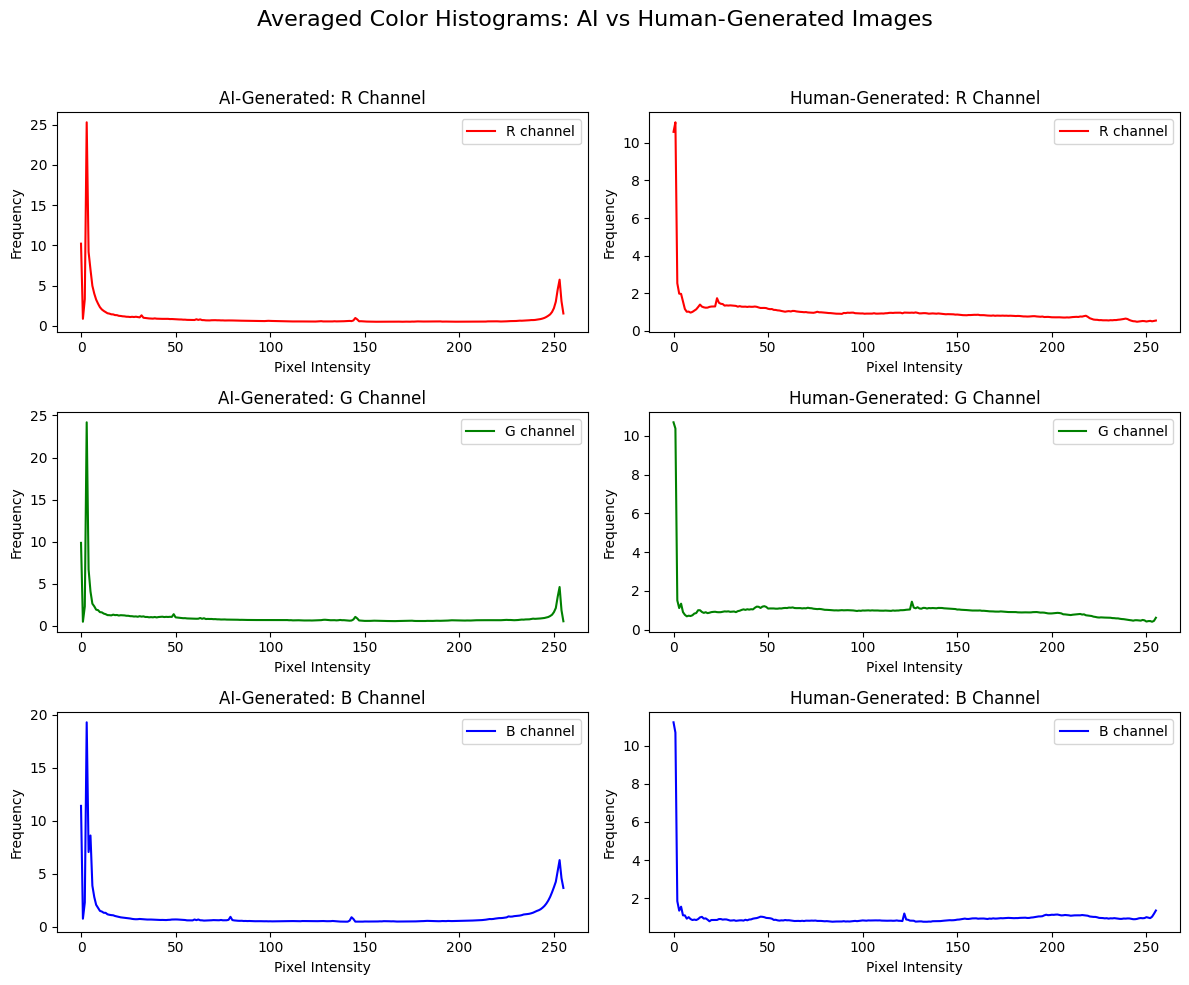

In [52]:
# Function to compute and plot color histograms for AI and Human images
def plot_color_histogram(dataset, num_samples=200):
    # Collect AI and Human images
    ai_images = []
    human_images = []
    for img, label in dataset:
        if label == 1 and len(ai_images) < num_samples:  # AI-generated (label = 1)
            ai_images.append(img)
        elif label == 0 and len(human_images) < num_samples:  # Human-generated (label = 0)
            human_images.append(img)
        if len(ai_images) == num_samples and len(human_images) == num_samples:
            break

    # Convert images to numpy arrays and compute histograms
    ai_hist = {'R': [], 'G': [], 'B': []}
    human_hist = {'R': [], 'G': [], 'B': []}
    
    for img in ai_images:
        img = denormalize(img).permute(1, 2, 0).numpy()  # Denormalize and convert to HWC
        for i, color in enumerate(['R', 'G', 'B']):
            hist, _ = np.histogram(img[:, :, i].flatten(), bins=256, range=(0, 1), density=True)
            ai_hist[color].append(hist)
    
    for img in human_images:
        img = denormalize(img).permute(1, 2, 0).numpy()
        for i, color in enumerate(['R', 'G', 'B']):
            hist, _ = np.histogram(img[:, :, i].flatten(), bins=256, range=(0, 1), density=True)
            human_hist[color].append(hist)

    # Compute average histograms
    ai_avg_hist = {color: np.mean(hists, axis=0) for color, hists in ai_hist.items()}
    human_avg_hist = {color: np.mean(hists, axis=0) for color, hists in human_hist.items()}

    # Plot histograms
    fig, axes = plt.subplots(3, 2, figsize=(12, 10))
    fig.suptitle("Averaged Color Histograms: AI vs Human-Generated Images", fontsize=16)
    colors = ['R', 'G', 'B']
    
    for i, color in enumerate(colors):
        # AI histogram
        axes[i, 0].plot(ai_avg_hist[color], color=color.lower(), label=f'{color} channel')
        axes[i, 0].set_title(f"AI-Generated: {color} Channel")
        axes[i, 0].set_xlabel("Pixel Intensity")
        axes[i, 0].set_ylabel("Frequency")
        axes[i, 0].legend()

        # Human histogram
        axes[i, 1].plot(human_avg_hist[color], color=color.lower(), label=f'{color} channel')
        axes[i, 1].set_title(f"Human-Generated: {color} Channel")
        axes[i, 1].set_xlabel("Pixel Intensity")
        axes[i, 1].set_ylabel("Frequency")
        axes[i, 1].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Plot color histograms using 200 samples from each class
plot_color_histogram(train_dataset, num_samples=200)

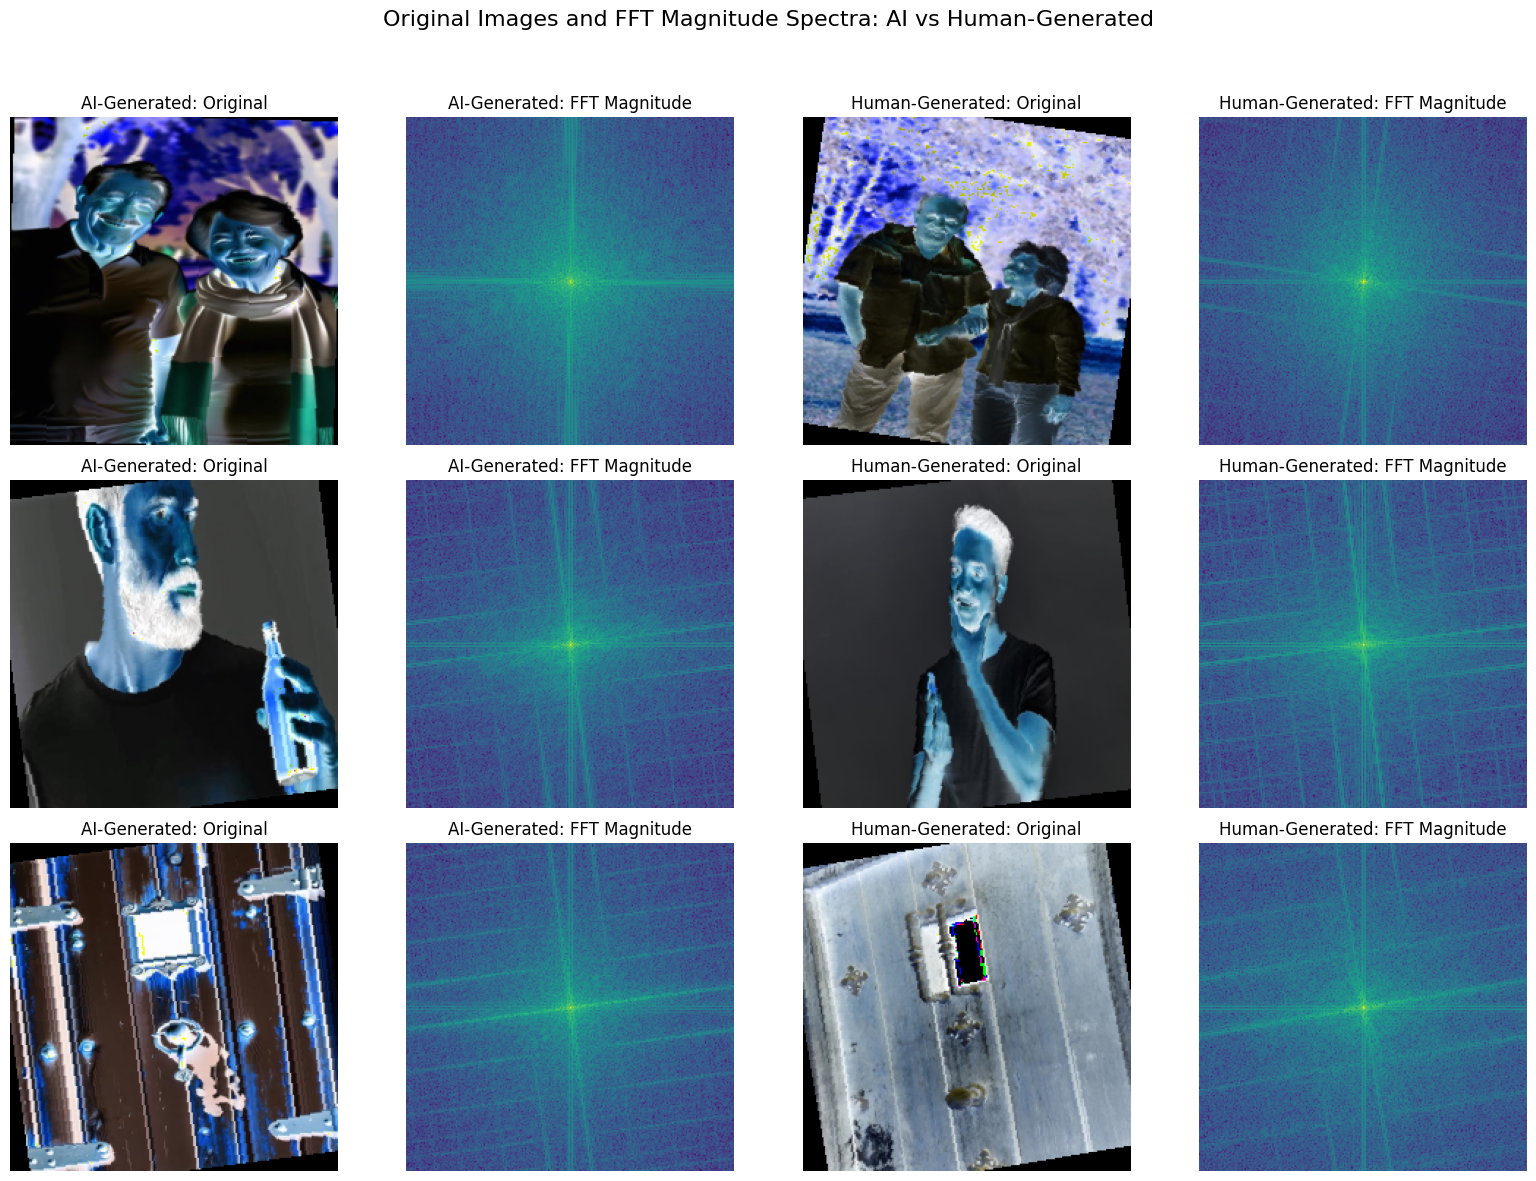

In [53]:
# Function to visualize FFT magnitude spectrum alongside original images
def plot_fft_magnitude(dataset, num_samples=3):
    # Collect AI and Human images
    ai_images = []
    human_images = []
    for img, label in dataset:
        if label == 1 and len(ai_images) < num_samples:  # AI-generated (label = 1)
            ai_images.append(img)
        elif label == 0 and len(human_images) < num_samples:  # Human-generated (label = 0)
            human_images.append(img)
        if len(ai_images) == num_samples and len(human_images) == num_samples:
            break

    # Plot original images and their FFT magnitude spectra
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))
    fig.suptitle("Original Images and FFT Magnitude Spectra: AI vs Human-Generated", fontsize=16)

    for i in range(num_samples):
        # AI original image
        ai_img = denormalize(ai_images[i]).permute(1, 2, 0).numpy()
        axes[i, 0].imshow(ai_img)
        axes[i, 0].set_title("AI-Generated: Original")
        axes[i, 0].axis('off')

        # AI FFT magnitude (4th channel)
        ai_fft = ai_images[i][3, :, :].numpy()  # FFT channel
        ai_fft = (ai_fft - ai_fft.min()) / (ai_fft.max() - ai_fft.min())  # Normalize for visualization
        axes[i, 1].imshow(ai_fft, cmap='viridis')
        axes[i, 1].set_title("AI-Generated: FFT Magnitude")
        axes[i, 1].axis('off')

        # Human original image
        human_img = denormalize(human_images[i]).permute(1, 2, 0).numpy()
        axes[i, 2].imshow(human_img)
        axes[i, 2].set_title("Human-Generated: Original")
        axes[i, 2].axis('off')

        # Human FFT magnitude (4th channel)
        human_fft = human_images[i][3, :, :].numpy()
        human_fft = (human_fft - human_fft.min()) / (human_fft.max() - human_fft.min())
        axes[i, 3].imshow(human_fft, cmap='viridis')
        axes[i, 3].set_title("Human-Generated: FFT Magnitude")
        axes[i, 3].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Visualize FFT magnitude spectra for 3 pairs of AI and Human images
plot_fft_magnitude(train_dataset, num_samples=3)

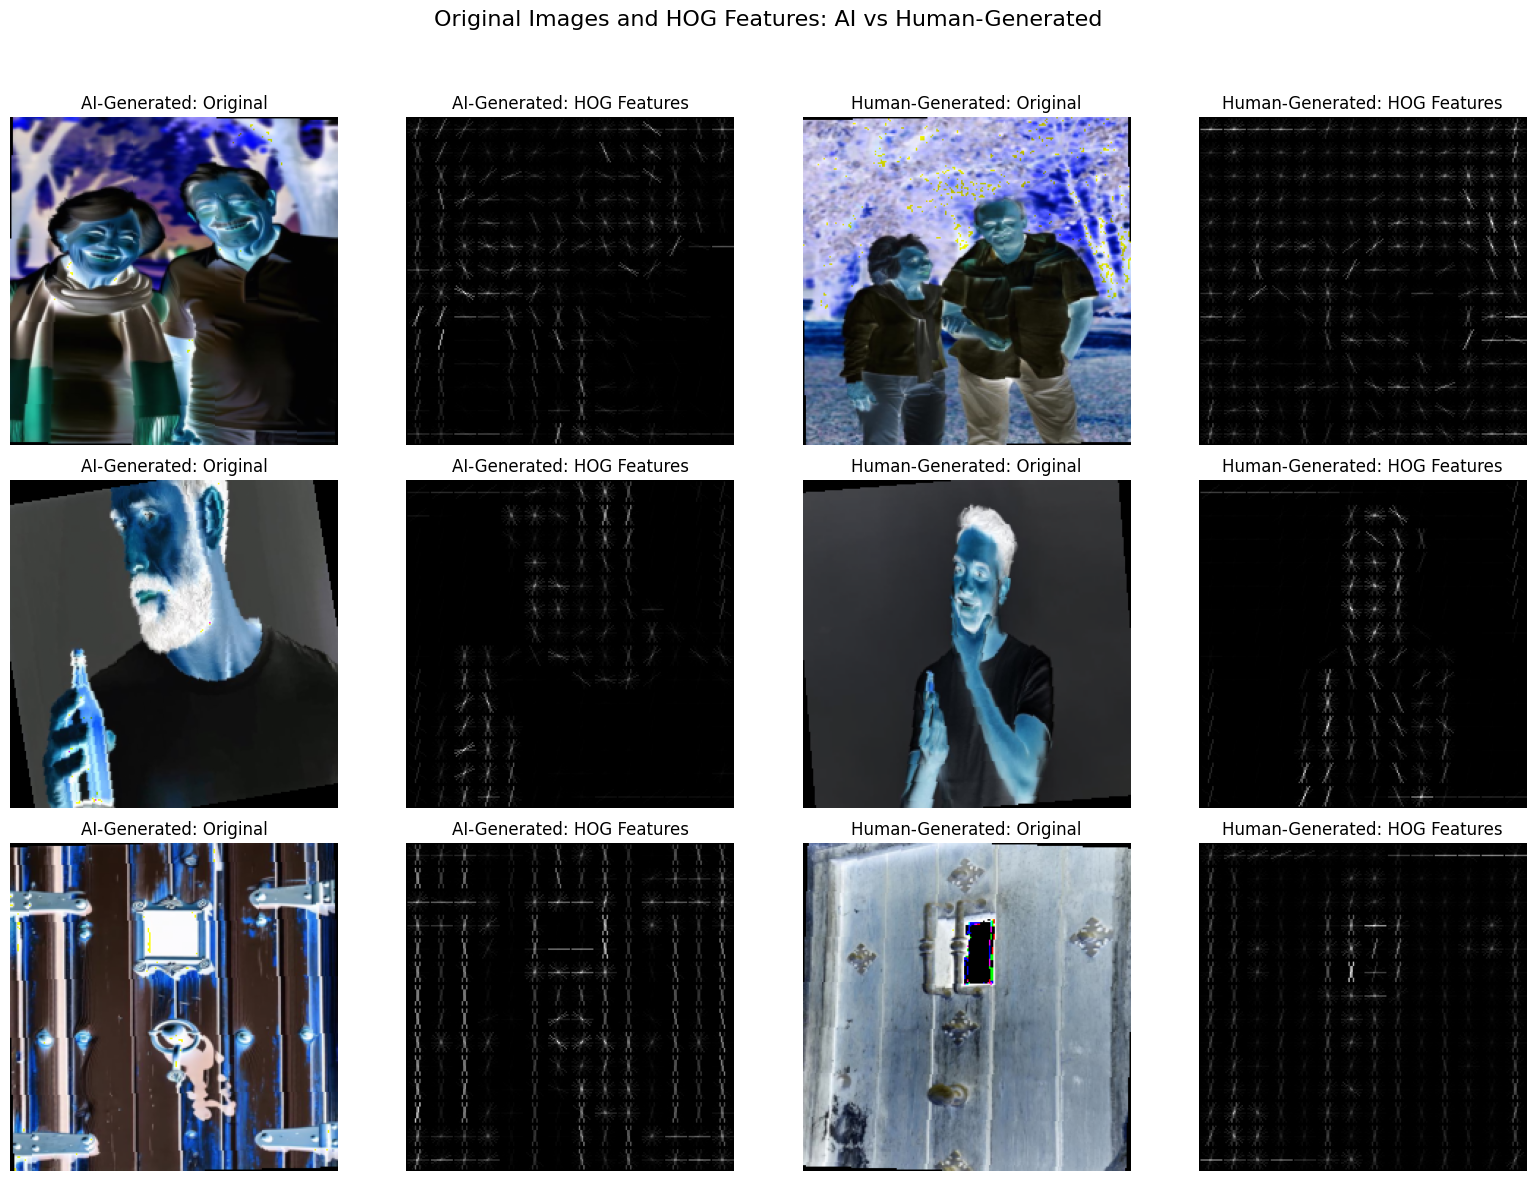

In [37]:
# Import library for HOG feature extraction
from skimage.feature import hog
from skimage import color

# Function to extract and visualize HOG features
def plot_hog_features(dataset, num_samples=3):
    # Collect AI and Human images
    ai_images = []
    human_images = []
    for img, label in dataset:
        if label == 1 and len(ai_images) < num_samples:  # AI-generated (label = 1)
            ai_images.append(img)
        elif label == 0 and len(human_images) < num_samples:  # Human-generated (label = 0)
            human_images.append(img)
        if len(ai_images) == num_samples and len(human_images) == num_samples:
            break

    # Plot original images and their HOG visualizations
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))
    fig.suptitle("Original Images and HOG Features: AI vs Human-Generated", fontsize=16)

    for i in range(num_samples):
        # AI original image
        ai_img = denormalize(ai_images[i]).permute(1, 2, 0).numpy()
        axes[i, 0].imshow(ai_img)
        axes[i, 0].set_title("AI-Generated: Original")
        axes[i, 0].axis('off')

        # AI HOG visualization
        ai_img_gray = color.rgb2gray(ai_img)
        _, ai_hog_img = hog(ai_img_gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)
        ai_hog_img = (ai_hog_img - ai_hog_img.min()) / (ai_hog_img.max() - ai_hog_img.min())  # Normalize for visualization
        axes[i, 1].imshow(ai_hog_img, cmap='gray')
        axes[i, 1].set_title("AI-Generated: HOG Features")
        axes[i, 1].axis('off')

        # Human original image
        human_img = denormalize(human_images[i]).permute(1, 2, 0).numpy()
        axes[i, 2].imshow(human_img)
        axes[i, 2].set_title("Human-Generated: Original")
        axes[i, 2].axis('off')

        # Human HOG visualization
        human_img_gray = color.rgb2gray(human_img)
        _, human_hog_img = hog(human_img_gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)
        human_hog_img = (human_hog_img - human_hog_img.min()) / (human_hog_img.max() - human_hog_img.min())
        axes[i, 3].imshow(human_hog_img, cmap='gray')
        axes[i, 3].set_title("Human-Generated: HOG Features")
        axes[i, 3].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Visualize HOG features for 3 pairs of AI and Human images
plot_hog_features(train_dataset, num_samples=3)

In [63]:
# List available CoAtNet models in timm
coatnet_models = timm.list_models('coatnet*')
print("Available CoAtNet models in timm:", coatnet_models)

# Choose a suitable CoAtNet model (e.g., coatnet_nano_rw_224 if available)
model_name = 'coatnet_nano_rw_224' if 'coatnet_nano_rw_224' in coatnet_models else coatnet_models[0]
print(f"Selected CoAtNet model: {model_name}")

# Define a custom CoAtNet model without HOG features
class CustomCoAtNet(nn.Module):
    def __init__(self, model_name=model_name, pretrained=True, num_classes=2):
        super().__init__()
        # Load the base CoAtNet model (without classifier)
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=0)
        # Modify the input conv layer to accept 4 channels (RGB + FFT)
        old_conv = self.model.stem.conv1
        self.model.stem.conv1 = nn.Conv2d(4, old_conv.out_channels, kernel_size=old_conv.kernel_size, 
                                         stride=old_conv.stride, padding=old_conv.padding, bias=False)
        with torch.no_grad():
            self.model.stem.conv1.weight[:, :3] = old_conv.weight
            self.model.stem.conv1.weight[:, 3] = old_conv.weight[:, 2]  # Copy weights for FFT channel
        
        # Define the final classifier (only image features)
        self.classifier = nn.Linear(self.model.num_features, num_classes)

    def forward(self, x):
        # Forward pass through the CoAtNet backbone (image features)
        img_features = self.model(x)
        # Final classification
        return self.classifier(img_features)

# Initialize the model
model = CustomCoAtNet(model_name=model_name, pretrained=True, num_classes=2)
model = model.to(device)

# Print model summary (optional)
print(model)

Available CoAtNet models in timm: ['coatnet_0_224', 'coatnet_0_rw_224', 'coatnet_1_224', 'coatnet_1_rw_224', 'coatnet_2_224', 'coatnet_2_rw_224', 'coatnet_3_224', 'coatnet_3_rw_224', 'coatnet_4_224', 'coatnet_5_224', 'coatnet_bn_0_rw_224', 'coatnet_nano_cc_224', 'coatnet_nano_rw_224', 'coatnet_pico_rw_224', 'coatnet_rmlp_0_rw_224', 'coatnet_rmlp_1_rw2_224', 'coatnet_rmlp_1_rw_224', 'coatnet_rmlp_2_rw_224', 'coatnet_rmlp_2_rw_384', 'coatnet_rmlp_3_rw_224', 'coatnet_rmlp_nano_rw_224']
Selected CoAtNet model: coatnet_nano_rw_224
CustomCoAtNet(
  (model): MaxxVit(
    (stem): Stem(
      (conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (stages): Sequential(
      (0): MaxxVitStage

In [65]:
# Import necessary libraries for training
from torch.amp import autocast, GradScaler  # Updated API for autocast and GradScaler
from tqdm import tqdm  # Import tqdm for progress bar

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Label smoothing to reduce overfitting
optimizer = optim.AdamW(model.parameters(), lr=1e-3)  # Optimize all parameters
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)  # Learning rate scheduling

# Mixed precision training for efficiency (updated API)
scaler = GradScaler('cuda')  # Specify device for GradScaler

# Training loop
def train_model(model, train_loader, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            with autocast('cuda'):  # Mixed precision (updated API)
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            running_loss += loss.item()
        
        # Update learning rate after optimizer step
        scheduler.step()
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

# Train the model for 5 epochs
train_model(model, train_loader, epochs=5)

# Save the trained model
torch.save(model.state_dict(), '/kaggle/working/coatnet_trained.pth')
print("Model saved to /kaggle/working/coatnet_trained.pth")

Epoch 1/5: 100%|██████████| 2499/2499 [10:57<00:00,  3.80it/s]


Epoch 1/5, Loss: 0.3712, Accuracy: 89.33%


Epoch 2/5: 100%|██████████| 2499/2499 [10:04<00:00,  4.13it/s]


Epoch 2/5, Loss: 0.2920, Accuracy: 94.41%


Epoch 3/5: 100%|██████████| 2499/2499 [10:02<00:00,  4.15it/s]


Epoch 3/5, Loss: 0.3215, Accuracy: 92.51%


Epoch 4/5: 100%|██████████| 2499/2499 [10:00<00:00,  4.16it/s]


Epoch 4/5, Loss: 0.3467, Accuracy: 90.92%


Epoch 5/5: 100%|██████████| 2499/2499 [10:16<00:00,  4.05it/s]


Epoch 5/5, Loss: 0.3145, Accuracy: 92.93%
Model saved to /kaggle/working/coatnet_trained.pth


Using device: cuda
Loaded trained model for prediction.


Predicting on test set:   0%|          | 0/174 [00:00<?, ?it/s]

Loading image: /kaggle/input/ai-vs-human-generated-dataset/test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg
Loading image: /kaggle/input/ai-vs-human-generated-dataset/test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg
Loading image: /kaggle/input/ai-vs-human-generated-dataset/test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg
Loading image: /kaggle/input/ai-vs-human-generated-dataset/test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg
Loading image: /kaggle/input/ai-vs-human-generated-dataset/test_data_v2/a16495c578b7494683805484ca27cf9f.jpg


Predicting on test set: 100%|██████████| 174/174 [02:58<00:00,  1.02s/it]


No duplicate IDs found in submission.
Submission file has 5540 rows (expected 5540).
Submission file saved to /kaggle/working/submission.csv


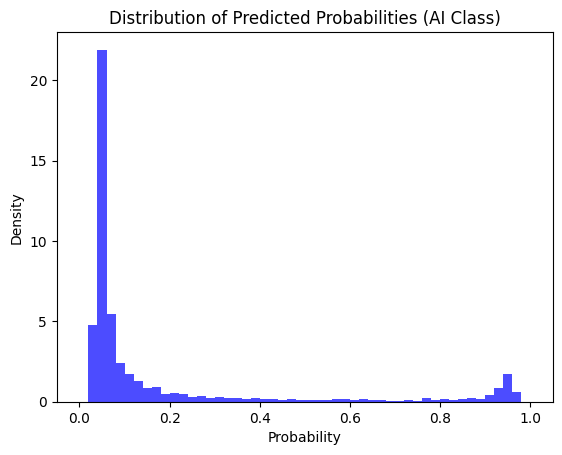

Mean probability: 0.1825
Min probability: 0.0228
Max probability: 0.9765
Percentage of predictions above 0.5: 12.64%


In [75]:
# Import necessary libraries
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load test.csv for IDs
test_df = pd.read_csv('/kaggle/input/ai-vs-human-generated-dataset/test.csv')
test_ids = test_df['id'].tolist()  # Get all test IDs

# Define test dataset class
class TestDataset(Dataset):
    def __init__(self, ids, root_dir, transform=None):
        self.ids = ids  # List of image paths (from test.csv)
        self.root_dir = root_dir  # Root directory for test_data_v2
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_path_raw = self.ids[idx]  # Get image path (e.g., test_data_v2/xxx.jpg)
        # Extract the filename by removing the directory prefix
        img_name = os.path.basename(img_path_raw)  # Remove 'test_data_v2/' prefix
        # Construct the full absolute path
        img_path = os.path.join(self.root_dir, img_name)
        # Debug: Print the path to verify
        if idx < 5:  # Print first 5 paths for debugging
            print(f"Loading image: {img_path}")
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_path_raw  # Return image and its ID

# Use the same transform as before (from Cell 3)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    FFTTransform(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406, 0.5], std=[0.229, 0.224, 0.225, 0.5])
])

# Create test dataset and loader
test_dataset = TestDataset(
    ids=test_ids,
    root_dir='/kaggle/input/ai-vs-human-generated-dataset/test_data_v2',
    transform=test_transform
)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,  # Ensure order matches test.csv
    num_workers=0,  # Avoid multi-threading issues
    pin_memory=True
)

# Load the trained model
model.load_state_dict(torch.load('/kaggle/working/coatnet_trained.pth', weights_only=True))
model.eval()
print("Loaded trained model for prediction.")

# Predict on test set and generate submission file
predictions = []
labels = []
ids = []

with torch.no_grad():
    for images, batch_ids in tqdm(test_loader, desc="Predicting on test set"):
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability of AI class (label 1)
        predictions.extend(probs.cpu().numpy())
        # Convert probabilities to binary labels (threshold 0.5)
        batch_labels = (probs > 0.5).long().cpu().numpy()
        labels.extend(batch_labels)
        # Use batch_ids directly from test_loader
        ids.extend(batch_ids)

# Create submission DataFrame with binary labels
submission = pd.DataFrame({'id': ids, 'Label': labels})

# Check for duplicate IDs
duplicate_ids = submission['id'].duplicated().sum()
if duplicate_ids > 0:
    print(f"Error: Found {duplicate_ids} duplicate IDs in submission!")
    duplicates = submission[submission['id'].duplicated(keep=False)]
    print("Duplicate IDs:")
    print(duplicates)
else:
    print("No duplicate IDs found in submission.")

# Check number of rows
print(f"Submission file has {len(submission)} rows (expected 5540).")

# Save submission file
submission.to_csv('/kaggle/working/submission.csv', index=False)
print("Submission file saved to /kaggle/working/submission.csv")

# Visualize the distribution of predicted probabilities
plt.hist(predictions, bins=50, range=(0, 1), density=True, alpha=0.7, color='blue')
plt.title("Distribution of Predicted Probabilities (AI Class)")
plt.xlabel("Probability")
plt.ylabel("Density")
plt.show()

# Print basic statistics of predictions
print(f"Mean probability: {sum(predictions) / len(predictions):.4f}")
print(f"Min probability: {min(predictions):.4f}")
print(f"Max probability: {max(predictions):.4f}")
print(f"Percentage of predictions above 0.5: {100 * sum(p > 0.5 for p in predictions) / len(predictions):.2f}%")